In [1]:
import random
from collections import deque
from copy import deepcopy

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
SEED = 1
BATCH_SIZE = 256
LR = 0.0003
UP_COEF = 0.1
GAMMA = 0.99
EPS = 1e-8

# set device
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

# random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)

In [3]:
class DuelingDQN(nn.Module):
    def __init__(self, obs_space, action_space):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, 256),
            nn.SELU()
        )

        self.val = nn.Sequential(
            nn.Linear(256, 256),
            nn.SELU(),
            nn.Linear(256, 1)
        )

        self.adv = nn.Sequential(
            nn.Linear(256, 256),
            nn.SELU(),
            nn.Linear(256, action_space)
        )

    def forward(self, x):
        out = self.head(x)
        val_out = self.val(out).reshape(out.shape[0], 1)
        adv_out = self.adv(out).reshape(out.shape[0], -1)
        adv_mean = adv_out.mean(dim=1, keepdim=True)
        q = val_out + adv_out - adv_mean

        return q

In [4]:
losses = []


def learn(net, tgt_net, optimizer, rep_memory):
    net.train()
    tgt_net.train()

    train_data = random.sample(rep_memory, BATCH_SIZE)
    dataloader = DataLoader(
        train_data, batch_size=BATCH_SIZE, pin_memory=use_cuda)
    # double DQN
    for i, (s, a, r, _s, d) in enumerate(dataloader):
        s_batch = s.to(device).float()
        a_batch = a.detach().to(device).long()
        _s_batch = _s.to(device).float()
        r_batch = r.detach().to(device).float()
        is_done = 1. - d.detach().reshape(BATCH_SIZE, 1).to(device).float()
        
        _q_batch = net(_s_batch)
        _a_batch = torch.argmax(_q_batch, dim=1)

        with torch.no_grad():
            _q_batch_tgt = tgt_net(_s_batch)
            done_mask = torch.cat(tuple(is_done for _ in range(action_space)), dim=1)
            _q_batch_tgt_masked = _q_batch_tgt * done_mask
            _q_best_tgt = _q_batch_tgt_masked[range(BATCH_SIZE), _a_batch]

        q_batch = net(s_batch)
        q_acting = q_batch[range(BATCH_SIZE), a_batch]

        # loss
        loss = ((r_batch + GAMMA*_q_best_tgt) - q_acting).pow(2).sum().mean()
        losses.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def select_action(obs, tgt_net):
    tgt_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        q = tgt_net(state)
        action = torch.argmax(q, dim=1)

    return action.item()

## Main

In [5]:
# make an environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
env = gym.make('MountainCar-v0')
# env = gym.make('LunarLander-v2')

env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

# hyperparameter
n_episodes = 1000
learn_start = 1500
memory_size = 50000
update_frq = 1
use_eps_decay = False
epsilon = 0.001
eps_min = 0.001
decay_rate = 0.0001
n_eval = env.spec.trials

# global values
total_steps = 0
learn_steps = 0
rewards = []
reward_eval = deque(maxlen=n_eval)
is_learned = False
is_solved = False

# make two nerual networks
net = DuelingDQN(obs_space, action_space).to(device)
target_net = deepcopy(net)

# make optimizer
optimizer = optim.Adam(net.parameters(), lr=LR, eps=EPS)

# make memory
rep_memory = deque(maxlen=memory_size)

/home/jay/anaconda3/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [6]:
use_cuda

True

In [7]:
env.spec.max_episode_steps

200

In [8]:
env.spec.trials

100

In [9]:
env.spec.reward_threshold

-110.0

In [10]:
# play
for i in range(1, n_episodes + 1):
    obs = env.reset()
    done = False
    ep_reward = 0
    while not done:
#         env.render()
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = select_action(obs, target_net)

        _obs, reward, done, _ = env.step(action)

        rep_memory.append((obs, action, reward, _obs, done))

        obs = _obs
        total_steps += 1
        ep_reward += reward

        if use_eps_decay:
            epsilon -= epsilon * decay_rate
            epsilon = max(eps_min, epsilon)

        if len(rep_memory) >= learn_start:
            if len(rep_memory) == learn_start:
                print('\n============  Start Learning  ============\n')
            learn(net, target_net, optimizer, rep_memory)
            learn_steps += 1

        if learn_steps == update_frq:
            # target smoothing update
            for t, n in zip(target_net.parameters(), net.parameters()):
                t.data = UP_COEF * n.data + (1 - UP_COEF) * t.data
            learn_steps = 0
    if done:
        rewards.append(ep_reward)
        reward_eval.append(ep_reward)
        print('{:3} Episode in {:5} steps, reward {:.2f}'.format(
            i, total_steps, ep_reward))

        if len(reward_eval) >= n_eval:
            if np.mean(reward_eval) >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, total_steps))
                torch.save(target_net.state_dict(),
                           f'./test/saved_models/{env.spec.id}_ep{i}_clear_model_dddqn.pt')
                break
env.close()

  1 Episode in   200 steps, reward -200.00
  2 Episode in   400 steps, reward -200.00
  3 Episode in   600 steps, reward -200.00
  4 Episode in   800 steps, reward -200.00
  5 Episode in  1000 steps, reward -200.00
  6 Episode in  1200 steps, reward -200.00
  7 Episode in  1400 steps, reward -200.00

============  Start Learning  ============

  8 Episode in  1600 steps, reward -200.00
  9 Episode in  1800 steps, reward -200.00
 10 Episode in  2000 steps, reward -200.00
 11 Episode in  2200 steps, reward -200.00
 12 Episode in  2400 steps, reward -200.00
 13 Episode in  2600 steps, reward -200.00
 14 Episode in  2800 steps, reward -200.00
 15 Episode in  3000 steps, reward -200.00
 16 Episode in  3200 steps, reward -200.00
 17 Episode in  3400 steps, reward -200.00
 18 Episode in  3600 steps, reward -200.00
 19 Episode in  3800 steps, reward -200.00
 20 Episode in  4000 steps, reward -200.00
 21 Episode in  4200 steps, reward -200.00
 22 Episode in  4400 steps, reward -200.00
 23 Episo

191 Episode in 31295 steps, reward -132.00
192 Episode in 31428 steps, reward -133.00
193 Episode in 31521 steps, reward -93.00
194 Episode in 31682 steps, reward -161.00
195 Episode in 31846 steps, reward -164.00
196 Episode in 31958 steps, reward -112.00
197 Episode in 32122 steps, reward -164.00
198 Episode in 32266 steps, reward -144.00
199 Episode in 32378 steps, reward -112.00
200 Episode in 32471 steps, reward -93.00
201 Episode in 32593 steps, reward -122.00
202 Episode in 32726 steps, reward -133.00
203 Episode in 32819 steps, reward -93.00
204 Episode in 32950 steps, reward -131.00
205 Episode in 33082 steps, reward -132.00
206 Episode in 33191 steps, reward -109.00
207 Episode in 33371 steps, reward -180.00
208 Episode in 33495 steps, reward -124.00
209 Episode in 33588 steps, reward -93.00
210 Episode in 33681 steps, reward -93.00
211 Episode in 33849 steps, reward -168.00
212 Episode in 34049 steps, reward -200.00
213 Episode in 34219 steps, reward -170.00
214 Episode in 3

383 Episode in 55548 steps, reward -121.00
384 Episode in 55634 steps, reward -86.00
385 Episode in 55737 steps, reward -103.00
386 Episode in 55831 steps, reward -94.00
387 Episode in 55936 steps, reward -105.00
388 Episode in 56026 steps, reward -90.00
389 Episode in 56135 steps, reward -109.00
390 Episode in 56228 steps, reward -93.00
391 Episode in 56319 steps, reward -91.00
392 Episode in 56426 steps, reward -107.00
393 Episode in 56546 steps, reward -120.00
394 Episode in 56652 steps, reward -106.00
395 Episode in 56804 steps, reward -152.00
396 Episode in 56924 steps, reward -120.00
397 Episode in 57035 steps, reward -111.00
398 Episode in 57143 steps, reward -108.00
399 Episode in 57249 steps, reward -106.00
400 Episode in 57354 steps, reward -105.00
401 Episode in 57467 steps, reward -113.00
402 Episode in 57576 steps, reward -109.00
403 Episode in 57727 steps, reward -151.00
404 Episode in 57875 steps, reward -148.00
405 Episode in 58024 steps, reward -149.00
406 Episode in 5

576 Episode in 77904 steps, reward -158.00
577 Episode in 78016 steps, reward -112.00
578 Episode in 78163 steps, reward -147.00
579 Episode in 78273 steps, reward -110.00
580 Episode in 78381 steps, reward -108.00
581 Episode in 78472 steps, reward -91.00
582 Episode in 78556 steps, reward -84.00
583 Episode in 78666 steps, reward -110.00
584 Episode in 78778 steps, reward -112.00
585 Episode in 78867 steps, reward -89.00
586 Episode in 78976 steps, reward -109.00
587 Episode in 79091 steps, reward -115.00
588 Episode in 79178 steps, reward -87.00
589 Episode in 79293 steps, reward -115.00
590 Episode in 79439 steps, reward -146.00
591 Episode in 79528 steps, reward -89.00
592 Episode in 79613 steps, reward -85.00
593 Episode in 79724 steps, reward -111.00
594 Episode in 79836 steps, reward -112.00
595 Episode in 79945 steps, reward -109.00
596 Episode in 80058 steps, reward -113.00
597 Episode in 80165 steps, reward -107.00
598 Episode in 80280 steps, reward -115.00
599 Episode in 80

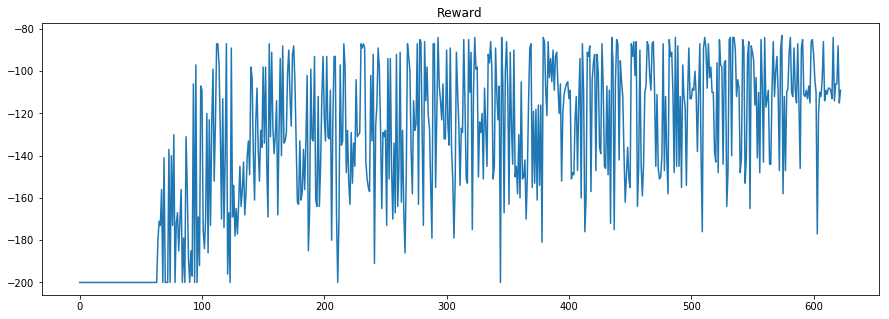

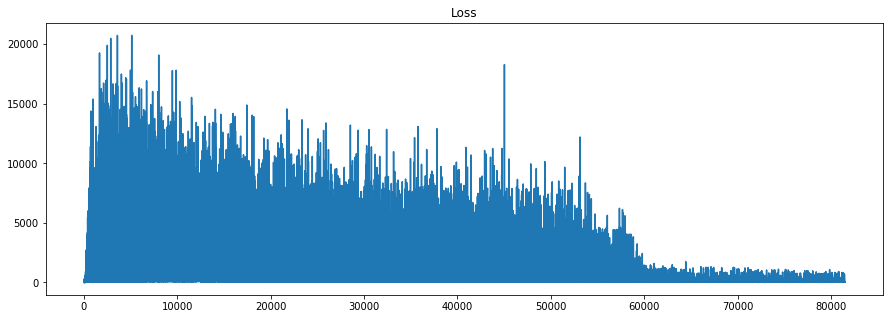

In [11]:
plt.figure(figsize=(15, 5))
plt.title('Reward')
plt.plot(rewards)
plt.figure(figsize=(15, 5))
plt.title('Loss')
plt.plot(losses)
plt.show()

In [12]:
[
    ('CartPole-v0', 412, 1),
    ('CartPole-v1', 398, 0.05),
    ('MountainCar-v0', 660, 0.1),
    ('LunarLander-v2', 260, 0.1)
]

[('CartPole-v0', 412, 1),
 ('CartPole-v1', 398, 0.05),
 ('MountainCar-v0', 660, 0.1),
 ('LunarLander-v2', 260, 0.1)]